In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt

from sklearn import model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

import gzip

import import_ipynb
from My_Functions import null_cols, rmse

importing Jupyter notebook from My_Functions.ipynb


In [2]:
acc_initial = pd.read_csv("acc_initial.csv.gz",
                          compression='gzip',
                          header=0,
                          sep=',',
                          quotechar='"')

target_initial = pd.read_csv("target_initial.csv.gz",
                             compression='gzip',
                             header=0,
                             sep=',',
                             quotechar='"')

acc_initial_ds = pd.read_csv("acc_initial_downsample.csv.gz",
                             compression='gzip',
                             header=0,
                             sep=',',
                             quotechar='"')

target_initial_ds = pd.read_csv("target_initial_downsample.csv.gz",
                                compression='gzip',
                                header=0,
                                sep=',',
                                quotechar='"')

In [3]:
state=0

# downsampled:
xtrain, xtest, ytrain, ytest = ms.train_test_split(acc_initial,
                                                   target_initial,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# downsampled:
xtrain_ds, xtest_ds, ytrain_ds, ytest_ds = ms.train_test_split(acc_initial_ds,
                                                               target_initial_ds,
                                                               test_size=0.2,
                                                               random_state=state)

# Must flatten to fit
ytrain_ds = ytrain_ds.values.flatten()


# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

## Original Data

In [4]:
xgb_clsfr = xgb.XGBClassifier()

train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

objective_ = ['binary:logistic']
evalmetric = ['auc']
uselabelencoder = [False]
treemethod = ['gpu_hist']
predictor_ = ['gpu_predictor']
njobs = [-1]
randomstate = [state]
booster_ = ['gbtree']

# nestimators = [100]
# minchildweight = [1, 5]
# maxdepth = [1, 3]
# learningrate = [0.1, 1]
# gamma_ = [0.5, 2]
# subsample_ = [0.8, 1]
# colsamplebytree = [0.8, 1]


gparam_xgb = {'objective': objective_,
                 'eval_metric': evalmetric,
                 'use_label_encoder': uselabelencoder,
                 'tree_method': treemethod,
                 'predictor': predictor_,
                 'n_jobs': njobs,
                 'booster': booster_,
#               'n_estimators': nestimators,
#               'min_child_weight': minchildweight,
#               'max_depth': maxdepth,
#               'learning_rate': learningrate,
#               'gamma': gamma_,
#               'subsample': subsample_,
#               'colsample_bytree': colsamplebytree,
                 'random_state': randomstate}


gs_xgb = ms.GridSearchCV(xgb_clsfr, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1,
                          scoring='roc_auc', return_train_score=True)

%time gs_xgb.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_xgb.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_xgb.best_estimator_.score(xtest, ytest))


# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb, ytrain, xtrain))
test_rmse.append(rmse(gs_xgb, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_xgb.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
res_df = pd.DataFrame(list_results).T
res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
res_df = pd.concat([res_df, best_par_df], axis=1, sort=False)

# confusion matrix for train set
print('\n')
print('confusion matrix for train set')
print(confusion_matrix(ytrain, gs_xgb.predict(xtrain)))

# confusion matrix for test set
print('\n')
print('confusion matrix for test set')
print(confusion_matrix(ytest, gs_xgb.predict(xtest)))

res_df

Wall time: 29.1 s


confusion matrix for train set
[[423705   7662]
 [ 91657  16216]]


confusion matrix for test set
[[105392   2611]
 [ 23724   3083]]


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,booster,eval_metric,n_jobs,objective,predictor,random_state,tree_method,use_label_encoder
0,0.815817,0.804651,0.429166,0.441983,-0.012817,gbtree,auc,-1,binary:logistic,gpu_predictor,0,gpu_hist,False


In [5]:
sorted_importance = sorted(zip(xtrain.columns,
                               gs_xgb.best_estimator_.feature_importances_),
                           key=lambda t:t[1], reverse=True)
sorted_importance

[('int_rate', 0.121761814),
 ('grade_B', 0.087953016),
 ('term_ 60 months', 0.037270594),
 ('grade_D', 0.024362464),
 ('grade_C', 0.019149711),
 ('mort_acc', 0.01621906),
 ('funded_amnt', 0.015606522),
 ('home_ownership_RENT', 0.015461577),
 ('home_ownership_MORTGAGE', 0.014098574),
 ('sub_grade_B5', 0.0124700675),
 ('acc_open_past_24mths', 0.01228732),
 ('avg_cur_bal', 0.012106737),
 ('purpose_small_business', 0.010992833),
 ('total_cu_tl', 0.0104447715),
 ('sub_grade_B4', 0.010367051),
 ('fico_range_low', 0.010282504),
 ('max_bal_bc', 0.009565598),
 ('num_actv_rev_tl', 0.009511937),
 ('dti', 0.009328223),
 ('funded_amnt_inv', 0.008639677),
 ('purpose_medical', 0.008156328),
 ('annual_inc', 0.008058833),
 ('initial_list_status_w', 0.008058231),
 ('sub_grade_C1', 0.007987082),
 ('sub_grade_D3', 0.007881918),
 ('verification_status_Source Verified', 0.00736332),
 ('loan_amnt', 0.0073133656),
 ('all_util', 0.0072429543),
 ('tot_hi_cred_lim', 0.007127619),
 ('total_bal_il', 0.0070407474),

In [6]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(ytest, gs_xgb.predict(xtest))

print('Average precision-recall score for random forest: {0:0.2f}'.format(
      average_precision))

Average precision-recall score for random forest: 0.24


Text(0.5, 1.0, '2-class Precision-Recall curve for random forest: AP=0.24')

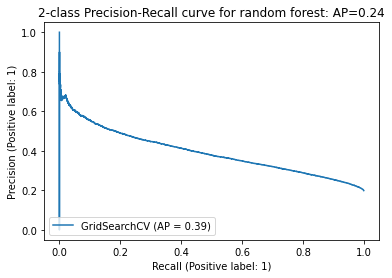

In [7]:
# Precision-Recall curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(gs_xgb, xtest, ytest)
disp.ax_.set_title('2-class Precision-Recall curve for random forest: '
                   'AP={0:0.2f}'.format(average_precision))

In [8]:
# F1 score 
# F1 = 2 * (precision * recall) / (precision + recall)

f1_score = metrics.f1_score(ytest, gs_xgb.predict(xtest))
recall_score = metrics.recall_score(ytest, gs_xgb.predict(xtest))
precision_score = metrics.precision_score(ytest, gs_xgb.predict(xtest))
print ("Random forest performance")
print ('-'*70)
print('F1 score: {0:0.2f}'.format(f1_score))
print('recall score: {0:0.2f}'.format(recall_score))
print('precision score: {0:0.2f}'.format(precision_score))

Random forest performance
----------------------------------------------------------------------
F1 score: 0.19
recall score: 0.12
precision score: 0.54


In [9]:
# ROC-AUC score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

from sklearn.metrics import roc_auc_score
print ("Random forest ROC-AUC score")
print ('-'*70)
roc_auc_score(ytest, gs_xgb.predict(xtest))

Random forest ROC-AUC score
----------------------------------------------------------------------


0.5454160099141693

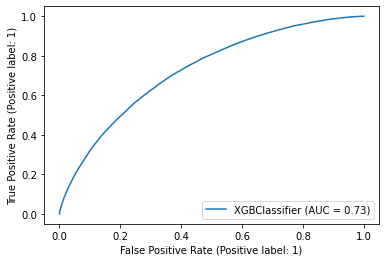

In [10]:
# Receiver operating characteristic (ROC) curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html#sklearn.metrics.plot_roc_curve

from sklearn import metrics
metrics.plot_roc_curve(gs_xgb.best_estimator_, xtest, ytest) 

In [11]:
filtered_sorted_importance = [x for x in sorted_importance if x[1]>0.003]
filtered_sorted_importance

[('int_rate', 0.121761814),
 ('grade_B', 0.087953016),
 ('term_ 60 months', 0.037270594),
 ('grade_D', 0.024362464),
 ('grade_C', 0.019149711),
 ('mort_acc', 0.01621906),
 ('funded_amnt', 0.015606522),
 ('home_ownership_RENT', 0.015461577),
 ('home_ownership_MORTGAGE', 0.014098574),
 ('sub_grade_B5', 0.0124700675),
 ('acc_open_past_24mths', 0.01228732),
 ('avg_cur_bal', 0.012106737),
 ('purpose_small_business', 0.010992833),
 ('total_cu_tl', 0.0104447715),
 ('sub_grade_B4', 0.010367051),
 ('fico_range_low', 0.010282504),
 ('max_bal_bc', 0.009565598),
 ('num_actv_rev_tl', 0.009511937),
 ('dti', 0.009328223),
 ('funded_amnt_inv', 0.008639677),
 ('purpose_medical', 0.008156328),
 ('annual_inc', 0.008058833),
 ('initial_list_status_w', 0.008058231),
 ('sub_grade_C1', 0.007987082),
 ('sub_grade_D3', 0.007881918),
 ('verification_status_Source Verified', 0.00736332),
 ('loan_amnt', 0.0073133656),
 ('all_util', 0.0072429543),
 ('tot_hi_cred_lim', 0.007127619),
 ('total_bal_il', 0.0070407474),

In [12]:
# get list of column names for easier application in the future
filter_important = []
for tup in filtered_sorted_importance:
    filter_important.append(tup[0])

filter_important

['int_rate',
 'grade_B',
 'term_ 60 months',
 'grade_D',
 'grade_C',
 'mort_acc',
 'funded_amnt',
 'home_ownership_RENT',
 'home_ownership_MORTGAGE',
 'sub_grade_B5',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'purpose_small_business',
 'total_cu_tl',
 'sub_grade_B4',
 'fico_range_low',
 'max_bal_bc',
 'num_actv_rev_tl',
 'dti',
 'funded_amnt_inv',
 'purpose_medical',
 'annual_inc',
 'initial_list_status_w',
 'sub_grade_C1',
 'sub_grade_D3',
 'verification_status_Source Verified',
 'loan_amnt',
 'all_util',
 'tot_hi_cred_lim',
 'total_bal_il',
 'installment',
 'verification_status_Verified',
 'total_bc_limit',
 'sec_app_fico_range_low',
 'collections_12_mths_ex_med',
 'purpose_vacation',
 'sub_grade_D1',
 'mths_since_recent_inq',
 'sec_app_inq_last_6mths',
 'emp_length_10 years',
 'mo_sin_old_rev_tl_op',
 'verification_status_joint_Verified',
 'total_rev_hi_lim',
 'num_rev_tl_bal_gt_0',
 'dti_joint',
 'delinq_2yrs',
 'emp_length_7 years',
 'grade_G',
 'mths_since_recent_bc',
 'num_actv_

# Downsampled Data

In [13]:
xgb_clsfr_ds = xgb.XGBClassifier()

train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

objective_ = ['binary:logistic']
evalmetric = ['auc']
uselabelencoder = [False]
treemethod = ['gpu_hist']
predictor_ = ['gpu_predictor']
njobs = [-1]
randomstate = [state]
booster_ = ['gbtree']

# nestimators = [100]
# minchildweight = [1, 5]
# maxdepth = [1, 3]
# learningrate = [0.1, 1]
# gamma_ = [0.5, 2]
# subsample_ = [0.8, 1]
# colsamplebytree = [0.8, 1]


gparam_xgb_ds = {'objective': objective_,
                 'eval_metric': evalmetric,
                 'use_label_encoder': uselabelencoder,
                 'tree_method': treemethod,
                 'predictor': predictor_,
                 'n_jobs': njobs,
                 'booster': booster_,
#               'n_estimators': nestimators,
#               'min_child_weight': minchildweight,
#               'max_depth': maxdepth,
#               'learning_rate': learningrate,
#               'gamma': gamma_,
#               'subsample': subsample_,
#               'colsample_bytree': colsamplebytree,
                 'random_state': randomstate}


gs_xgb_ds = ms.GridSearchCV(xgb_clsfr_ds, gparam_xgb_ds, cv=n_folds, refit=True, n_jobs=-1,
                          scoring='roc_auc', return_train_score=True)

%time gs_xgb_ds.fit(xtrain_ds, ytrain_ds)

# setting up dataframe for results
train_scores.append(gs_xgb_ds.best_estimator_.score(xtrain_ds, ytrain_ds))
test_scores.append(gs_xgb_ds.best_estimator_.score(xtest_ds, ytest_ds))


# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_ds, ytrain_ds, xtrain_ds))
test_rmse.append(rmse(gs_xgb_ds, ytest_ds, xtest_ds))

# add the best parameters to the df
best_par_list.append(gs_xgb_ds.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
res_df = pd.DataFrame(list_results).T
res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
res_df = pd.concat([res_df, best_par_df], axis=1, sort=False)

# confusion matrix for train set
print('\n')
print('confusion matrix for train set')
print(confusion_matrix(ytrain_ds, gs_xgb_ds.predict(xtrain_ds)))

# confusion matrix for test set
print('\n')
print('confusion matrix for test set')
print(confusion_matrix(ytest_ds, gs_xgb_ds.predict(xtest_ds)))

res_df

Wall time: 15.2 s


confusion matrix for train set
[[75640 32070]
 [29570 78208]]


confusion matrix for test set
[[17497  9473]
 [ 8625 18277]]


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,booster,eval_metric,n_jobs,objective,predictor,random_state,tree_method,use_label_encoder
0,0.713952,0.664056,0.534835,0.579607,-0.044772,gbtree,auc,-1,binary:logistic,gpu_predictor,0,gpu_hist,False


In [14]:
sorted_importance = sorted(zip(xtrain_ds.columns,
                               gs_xgb_ds.best_estimator_.feature_importances_),
                           key=lambda t:t[1], reverse=True)
sorted_importance

[('int_rate', 0.13495792),
 ('term_ 60 months', 0.04060569),
 ('grade_C', 0.029782958),
 ('home_ownership_MORTGAGE', 0.02616637),
 ('grade_D', 0.020567523),
 ('grade_B', 0.018797182),
 ('home_ownership_RENT', 0.015427485),
 ('avg_cur_bal', 0.013304356),
 ('acc_open_past_24mths', 0.013275657),
 ('mort_acc', 0.011543607),
 ('purpose_small_business', 0.010741185),
 ('num_actv_rev_tl', 0.010709896),
 ('total_cu_tl', 0.010606778),
 ('dti', 0.010114022),
 ('funded_amnt', 0.009562384),
 ('sec_app_fico_range_low', 0.009561759),
 ('fico_range_low', 0.009349659),
 ('all_util', 0.009177409),
 ('sub_grade_C1', 0.008891337),
 ('funded_amnt_inv', 0.008700782),
 ('installment', 0.00844077),
 ('annual_inc', 0.008371061),
 ('delinq_2yrs', 0.008290611),
 ('max_bal_bc', 0.008184841),
 ('sub_grade_C2', 0.0077762464),
 ('sub_grade_F1', 0.007593634),
 ('verification_status_Source Verified', 0.0075656804),
 ('purpose_vacation', 0.007373285),
 ('loan_amnt', 0.0072820135),
 ('initial_list_status_w', 0.00715825

In [15]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))

print('Average precision-recall score for random forest: {0:0.2f}'.format(
      average_precision))

Average precision-recall score for random forest: 0.61


Text(0.5, 1.0, '2-class Precision-Recall curve for random forest: AP=0.61')

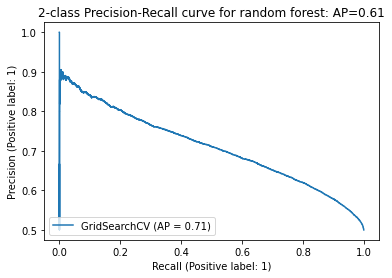

In [16]:
# Precision-Recall curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(gs_xgb_ds, xtest_ds, ytest_ds)
disp.ax_.set_title('2-class Precision-Recall curve for random forest: '
                   'AP={0:0.2f}'.format(average_precision))

In [17]:
# F1 score 
# F1 = 2 * (precision * recall) / (precision + recall)

f1_score = metrics.f1_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))
recall_score = metrics.recall_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))
precision_score = metrics.precision_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))
print ("Random forest performance")
print ('-'*70)
print('F1 score: {0:0.2f}'.format(f1_score))
print('recall score: {0:0.2f}'.format(recall_score))
print('precision score: {0:0.2f}'.format(precision_score))

Random forest performance
----------------------------------------------------------------------
F1 score: 0.67
recall score: 0.68
precision score: 0.66


In [18]:
# ROC-AUC score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

from sklearn.metrics import roc_auc_score
print ("Random forest ROC-AUC score")
print ('-'*70)
roc_auc_score(ytest_ds, gs_xgb_ds.predict(xtest_ds))

Random forest ROC-AUC score
----------------------------------------------------------------------


0.6640748729503291

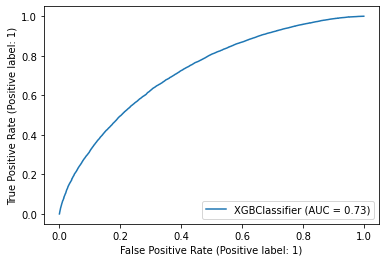

In [19]:
# Receiver operating characteristic (ROC) curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html#sklearn.metrics.plot_roc_curve

from sklearn import metrics
metrics.plot_roc_curve(gs_xgb_ds.best_estimator_, xtest_ds, ytest_ds) 

In [20]:
filtered_sorted_importance = [x for x in sorted_importance if x[1]>0.003]
filtered_sorted_importance

[('int_rate', 0.13495792),
 ('term_ 60 months', 0.04060569),
 ('grade_C', 0.029782958),
 ('home_ownership_MORTGAGE', 0.02616637),
 ('grade_D', 0.020567523),
 ('grade_B', 0.018797182),
 ('home_ownership_RENT', 0.015427485),
 ('avg_cur_bal', 0.013304356),
 ('acc_open_past_24mths', 0.013275657),
 ('mort_acc', 0.011543607),
 ('purpose_small_business', 0.010741185),
 ('num_actv_rev_tl', 0.010709896),
 ('total_cu_tl', 0.010606778),
 ('dti', 0.010114022),
 ('funded_amnt', 0.009562384),
 ('sec_app_fico_range_low', 0.009561759),
 ('fico_range_low', 0.009349659),
 ('all_util', 0.009177409),
 ('sub_grade_C1', 0.008891337),
 ('funded_amnt_inv', 0.008700782),
 ('installment', 0.00844077),
 ('annual_inc', 0.008371061),
 ('delinq_2yrs', 0.008290611),
 ('max_bal_bc', 0.008184841),
 ('sub_grade_C2', 0.0077762464),
 ('sub_grade_F1', 0.007593634),
 ('verification_status_Source Verified', 0.0075656804),
 ('purpose_vacation', 0.007373285),
 ('loan_amnt', 0.0072820135),
 ('initial_list_status_w', 0.00715825

In [21]:
# get list of column names for easier application in the future
filter_important = []
for tup in filtered_sorted_importance:
    filter_important.append(tup[0])

filter_important

['int_rate',
 'term_ 60 months',
 'grade_C',
 'home_ownership_MORTGAGE',
 'grade_D',
 'grade_B',
 'home_ownership_RENT',
 'avg_cur_bal',
 'acc_open_past_24mths',
 'mort_acc',
 'purpose_small_business',
 'num_actv_rev_tl',
 'total_cu_tl',
 'dti',
 'funded_amnt',
 'sec_app_fico_range_low',
 'fico_range_low',
 'all_util',
 'sub_grade_C1',
 'funded_amnt_inv',
 'installment',
 'annual_inc',
 'delinq_2yrs',
 'max_bal_bc',
 'sub_grade_C2',
 'sub_grade_F1',
 'verification_status_Source Verified',
 'purpose_vacation',
 'loan_amnt',
 'initial_list_status_w',
 'dti_joint',
 'sub_grade_C4',
 'verification_status_Verified',
 'total_bal_il',
 'collections_12_mths_ex_med',
 'sub_grade_D5',
 'grade_F',
 'tot_hi_cred_lim',
 'mths_since_recent_inq',
 'acc_now_delinq',
 'mo_sin_old_rev_tl_op',
 'sec_app_mort_acc',
 'purpose_renewable_energy',
 'purpose_medical',
 'sec_app_inq_last_6mths',
 'sub_grade_E3',
 'sub_grade_D2',
 'emp_length_4 years',
 'sub_grade_A3',
 'sub_grade_F4',
 'emp_length_10 years',
 '